### Initialization of pandas dataframe

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

original_df = pd.read_csv("raw_data.csv")
original_df = original_df.drop(columns=['index'])

In [ ]:
import requests

urls = [
    'https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Light.ttf',
    'https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Regular.ttf',
    'https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Medium.ttf',
    'https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Bold.ttf'
]

for url in urls:
    filename = url.split('/')[-1]
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)


In [ ]:
# @title Typesetting
# https://stackoverflow.com/a/65841091
from matplotlib import font_manager as fm, pyplot as plt

font_files = fm.findSystemFonts('.')

# Install fonts
for font_file in font_files:
  fm.fontManager.addfont(font_file)

In [ ]:
# @title Colors
colors = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000", "#000000", "#FFFFFF"]
colors_grad = sns.color_palette('flare_r',  12)
colors_heat1 = sns.color_palette('flare_r', as_cmap=True)
colors_heat2 = sns.diverging_palette(315, 261, s=74, l=50, center='dark', as_cmap=True)

color_bg = "#1B181C"
color_text = "#FFFFFF"

In [ ]:
# @title Plot settings
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams["figure.figsize"] = 16,8

# Text
mpl.rcParams['font.family'] = 'Roboto'

# Title
mpl.rcParams['figure.titlesize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.titleweight'] = 'bold'

# Labels
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22

# Spacing
mpl.rcParams['axes.titlepad'] = 72
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['xtick.major.pad'] = 10
mpl.rcParams['ytick.major.pad'] = 10
mpl.rcParams['xtick.major.width'] = 0
mpl.rcParams['xtick.minor.width'] = 0
mpl.rcParams['ytick.major.width'] = 0
mpl.rcParams['ytick.minor.width'] = 0

# Spines and grids
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

# Legends
mpl.rcParams['legend.title_fontsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = False

# Bars
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'

# Colors
mpl.rcParams["figure.facecolor"] = color_bg
mpl.rcParams["axes.facecolor"] = color_bg
mpl.rcParams["savefig.facecolor"] = color_bg

# Text colors
mpl.rcParams['text.color'] = color_text
mpl.rcParams['axes.labelcolor'] = color_text
mpl.rcParams['xtick.color'] = color_text
mpl.rcParams['ytick.color'] = color_text

# Line colors
mpl.rcParams['axes.edgecolor'] = color_text

### Dropping Palawan rows since suspicious yung data nila

In [11]:
df = original_df[original_df['crop'] != 'PALAWAN, YELLOW, 1 KG']
df = df.query("month != 'Annual'")

In [12]:
df['category'].unique()

array(['CEREALS', 'ROOTCROPS', 'BEANS & LEGUMES', 'CONDIMENTS',
       'FRUIT VEGETABLES', 'LEAFY VEGETABLES', 'FRUITS',
       'COMMERCIAL CROPS', 'LIVESTOCK', 'POULTRY', 'FISH'], dtype=object)

### Convert Month and Year to numeric value

In [13]:
# Convert month to numeric
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['month_numeric'] = df['month'].map(month_dict)

# Combine month and year to a numeric column
df['month_year_numeric'] = df['year'] * 100 + df['month_numeric']

In [14]:
df

,crop,month,year,price,category,month_numeric,month_year_numeric
0,"RICE, WELL-MILLED, 1 KG",Jan,2020,43.02,CEREALS,1,202001
1,"RICE, WELL-MILLED, 1 KG",Feb,2020,42.86,CEREALS,2,202002
2,"RICE, WELL-MILLED, 1 KG",Mar,2020,42.66,CEREALS,3,202003
3,"RICE, WELL-MILLED, 1 KG",Apr,2020,43.61,CEREALS,4,202004
4,"RICE, WELL-MILLED, 1 KG",May,2020,43.88,CEREALS,5,202005
...,...,...,...,...,...,...,...
10446,"FRESH SEAWEEDS, LATO, 1 KG",Aug,2023,151.58,FISH,8,202308
10447,"FRESH SEAWEEDS, LATO, 1 KG",Sep,2023,151.16,FISH,9,202309
10448,"FRESH SEAWEEDS, LATO, 1 KG",Oct,2023,150.75,FISH,10,202310
10449,"FRESH SEAWEEDS, LATO, 1 KG",Nov,2023,151.58,FISH,11,202311


### Prepare Crop Combinations

In [15]:
from itertools import combinations
import numpy as np

# unique_categories = df['category'].unique()
# print(unique_categories)

# unique_crops = df.query("category == 'FISH'")
# unique_crops = unique_crops['crop'].unique()
# unique_crops = np.append("RICE, WELL-MILLED, 1 KG", unique_crops)

# print(unique_crops)
#unique_crops = df['crop'].unique()

unique_crops = ["RICE, WELL-MILLED, 1 KG",
                "WHOLE CORN GRAIN, YELLOW, 1 KG",
                "POTATO, 1 KG",
                "RAW PEANUT, SHELLED, 1 KG",
                "GINGER, LOOSE, 1 KG",
                "CHAYOTE, 1 KG",
                "CAMOTE TOPS, 1 KG",
                "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
                "YOUNG COCONUT, MEDIUM, 1 PC",
                "FRESH BEEF, PURE MEAT, 1 KG",
                "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
                "FRESH CHICKEN, NATIVE, 1 KG",
                "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
                "FRESH FISH, TILAPIA, MEDIUM, 1 KG",
                "FRESH SHRIMP, ACETES, MEDIUM, 1 KG"
            ]

crop_pairs = list(combinations(unique_crops, 2))
correlation_results = {}

### Compute Pearson correlation between the prices of the two crops

In [16]:
# Loop through each crop pair
for crop1, crop2 in crop_pairs:
    # Select data for the first crop
    
    # ###########################RICE ONLY FOR CROP 1################################
    # if crop1 != 'RICE, WELL-MILLED, 1 KG':
    #     continue
    # ###########################RICE ONLY FOR CROP 1################################
    
    crop1_data = df[df['crop'] == crop1]
    
    # Select data for the second crop
    crop2_data = df[df['crop'] == crop2]
    
    # if crop1_data['category'].unique() == crop2_data['category'].unique():
    #     continue
    
    # Merge data for the two crops based on 'year' and 'month'
    merged_data = pd.merge(crop1_data, crop2_data, on=['year', 'month'])
    
    # Compute Pearson correlation between the prices of the two crops
    correlation = merged_data['price_x'].corr(merged_data['price_y'])
    
    # Store the correlation coefficient in the dictionary
    correlation_results[(crop1, crop2)] = correlation

# Convert dictionary to DataFrame for easier analysis
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson Correlation'])

### Create a correlation matrix

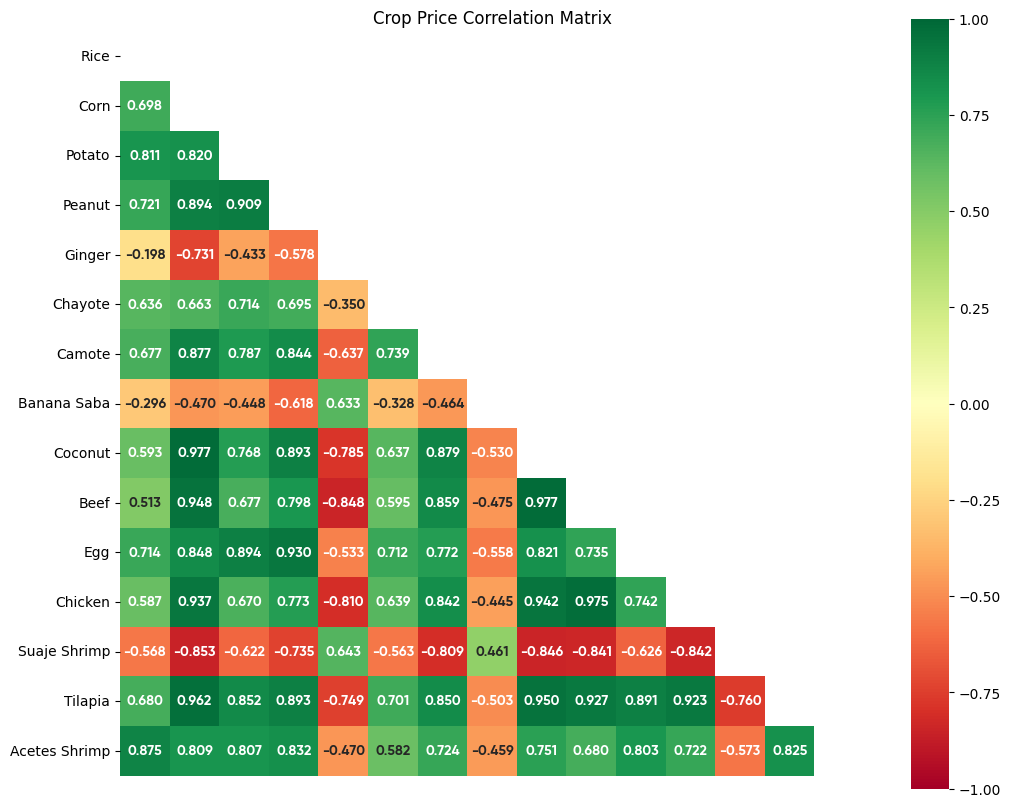

In [22]:
correlation_matrix = pd.DataFrame(index=unique_crops, columns=unique_crops)

# Fill in the correlation matrix
for (crop1, crop2), correlation in correlation_results.items():
    correlation_matrix.at[crop1, crop2] = correlation
    correlation_matrix.at[crop2, crop1] = correlation

# Ensure diagonal values are 1 (self-correlation)
for crop in unique_crops:
    correlation_matrix.at[crop, crop] = 1

# Optionally, visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Rice','Corn','Potato','Peanut','Ginger','Chayote','Camote','Banana Saba','Coconut','Beef','Egg','Chicken','Suaje Shrimp','Tilapia','Acetes Shrimp']
custom = sns.diverging_palette(145, 300, s=60, as_cmap=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
BuRd = plt.cm.RdBu_r
plt.figure(figsize=(12, 10))
sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix.astype(float), 
            mask=mask,
            annot=True, 
            cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1,
            linewidths=0, 
            fmt=".3f",
            xticklabels=False,
            yticklabels=labels,
            square=True,
            cbar=True,
            cbar_kws={
            },
            annot_kws={
                'fontsize':10,
                'fontweight':'bold',
                'fontfamily' : 'Gilroy',
            },
            )
plt.title('Crop Price Correlation Matrix')
plt.show()

### Print correlations

In [18]:
sorted_correlation_df = correlation_df.sort_values(by='Pearson Correlation', ascending=False)

# Display the top 10 correlations
print("Top correlations:")
sorted_correlation_df.head(20)

Top correlations:


,Pearson Correlation
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH BEEF, PURE MEAT, 1 KG)",0.977082
"(WHOLE CORN GRAIN, YELLOW, 1 KG, YOUNG COCONUT, MEDIUM, 1 PC)",0.976660
"(FRESH BEEF, PURE MEAT, 1 KG, FRESH CHICKEN, NATIVE, 1 KG)",0.974549
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.961580
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.950468
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH BEEF, PURE MEAT, 1 KG)",0.947860
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH CHICKEN, NATIVE, 1 KG)",0.942305
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH CHICKEN, NATIVE, 1 KG)",0.936554
"(RAW PEANUT, SHELLED, 1 KG, FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC)",0.930207
"(FRESH BEEF, PURE MEAT, 1 KG, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.926681


### Kruskal Willis Test for seasonality (function)

In [23]:
from scipy.stats import kruskal
import calendar

def seasonality_analysis(df, unique_crops):
    results = []

    for crop in unique_crops:
        crop_data = df[df['crop'] == crop]

        #mean and sd per month
        monthly_stats = crop_data.groupby('month')['price'].agg(['mean', 'std']).reset_index()
        
        # sort months
        months_ordered = [month for month in calendar.month_abbr if month in monthly_stats['month'].unique()]
        monthly_stats = monthly_stats.set_index('month').loc[months_ordered].reset_index()

        #overall mean
        overall_mean = crop_data['price'].mean()
        overall_std = crop_data['price'].std()

        #compute monthly differences against the overall
        monthly_diff_from_overall_mean = monthly_stats['mean'] - overall_mean
        
        # calculate z score
        sigma_diff_from_overall_mean = monthly_diff_from_overall_mean / overall_std
        
        # kruskal willis test
        grouped_data = [crop_data[crop_data['month'] == month]['price'].values for month in months_ordered]
        h_stat, p_value = kruskal(*grouped_data)
        seasonal = 'Yes' if p_value < 0.05 else 'No'
        
        #prepare results
        results.append({
            'crop': crop,
            'seasonal?': seasonal,
            'mean_per_month': monthly_stats['mean'].tolist(),
            'months': monthly_stats['month'].tolist(),
            'sigma_diff_from_overall_mean': sigma_diff_from_overall_mean.tolist()
        })
    
    return results

seasonality_results = seasonality_analysis(df, unique_crops)


### Plot into graph

Original, everything combined

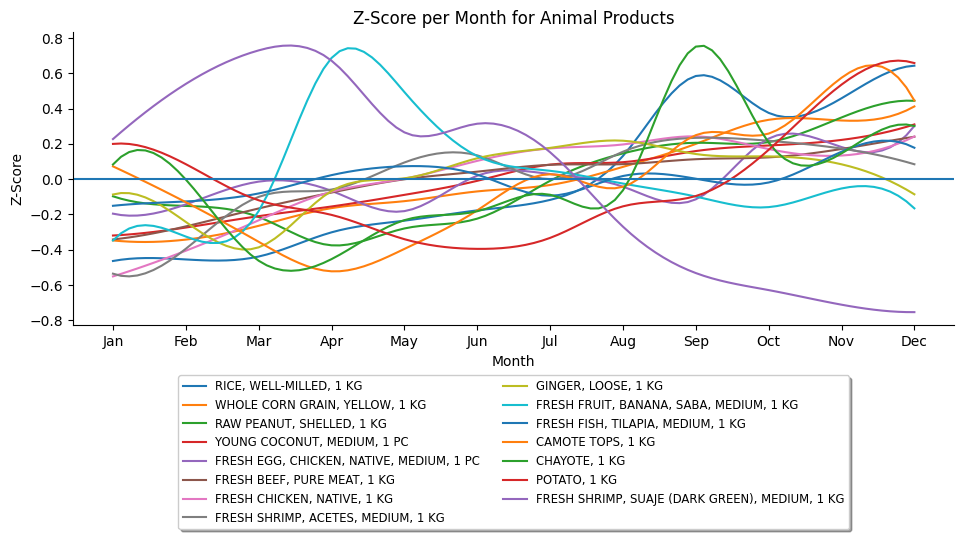

In [33]:
from scipy.interpolate import splrep, splev

def plot_sd_difference(seasonality_results, unique_crops):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:        
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        # print(f"{crop}:")
        # for i in range (12):
        #     print(f"{months[i]}: {round(sd_diff[i],3)}")
        if result['crop'] not in unique_crops:
            continue
        
        # convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # cubic spline interpolation
        spline = splrep(month_numbers, sd_diff, k=3)
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        #plt.plot(month_numbers, sd_diff, 'o') #original points
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('Z-Score per Month for Animal Products')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(False)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)
    plt.axhline()
    plt.show()
    
unique_crops = ["RICE, WELL-MILLED, 1 KG",
                "WHOLE CORN GRAIN, YELLOW, 1 KG",
                "POTATO, 1 KG",
                "RAW PEANUT, SHELLED, 1 KG",
                "GINGER, LOOSE, 1 KG",
                "CHAYOTE, 1 KG",
                "CAMOTE TOPS, 1 KG",
                "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
                "YOUNG COCONUT, MEDIUM, 1 PC",
                "FRESH BEEF, PURE MEAT, 1 KG",
                "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
                "FRESH CHICKEN, NATIVE, 1 KG",
                "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
                "FRESH FISH, TILAPIA, MEDIUM, 1 KG",
                "FRESH SHRIMP, ACETES, MEDIUM, 1 KG"
            ]

plot_sd_difference(seasonality_results, unique_crops)

Group A: Grains and Starches

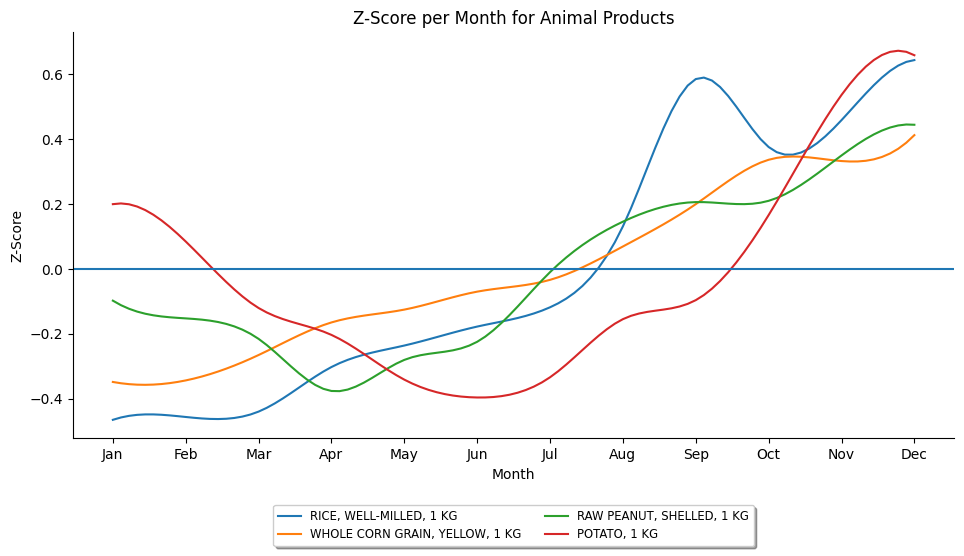

In [38]:
category_a = [
            "RICE, WELL-MILLED, 1 KG",
            "WHOLE CORN GRAIN, YELLOW, 1 KG",
            "POTATO, 1 KG",
            "RAW PEANUT, SHELLED, 1 KG"
        ]
plot_sd_difference(seasonality_results, category_a)

Group B: Fruit, Vegetables, Roots

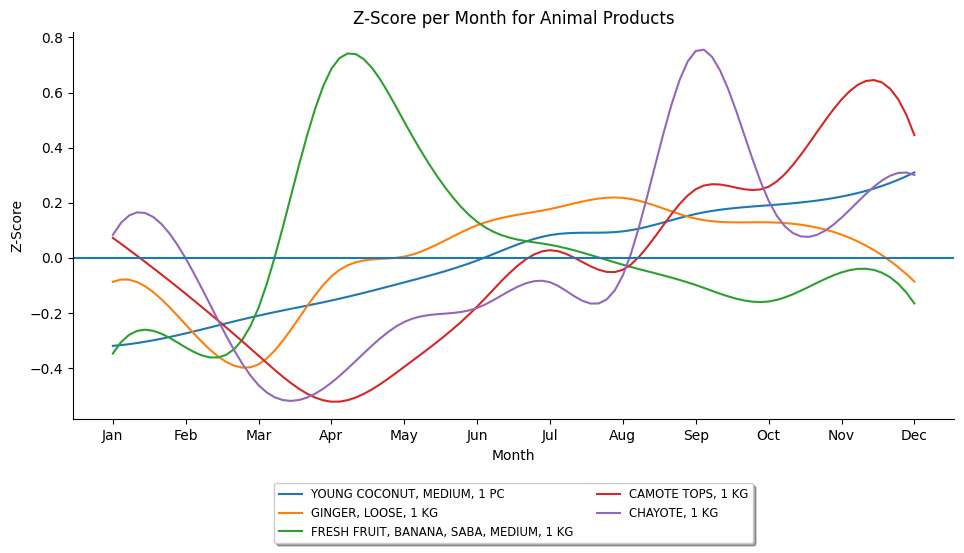

In [35]:
category_b = [
            "GINGER, LOOSE, 1 KG",
            "CHAYOTE, 1 KG",
            "CAMOTE TOPS, 1 KG",
            "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
            "YOUNG COCONUT, MEDIUM, 1 PC"
        ]
plot_sd_difference(seasonality_results, category_b)


Group C: Animal Products

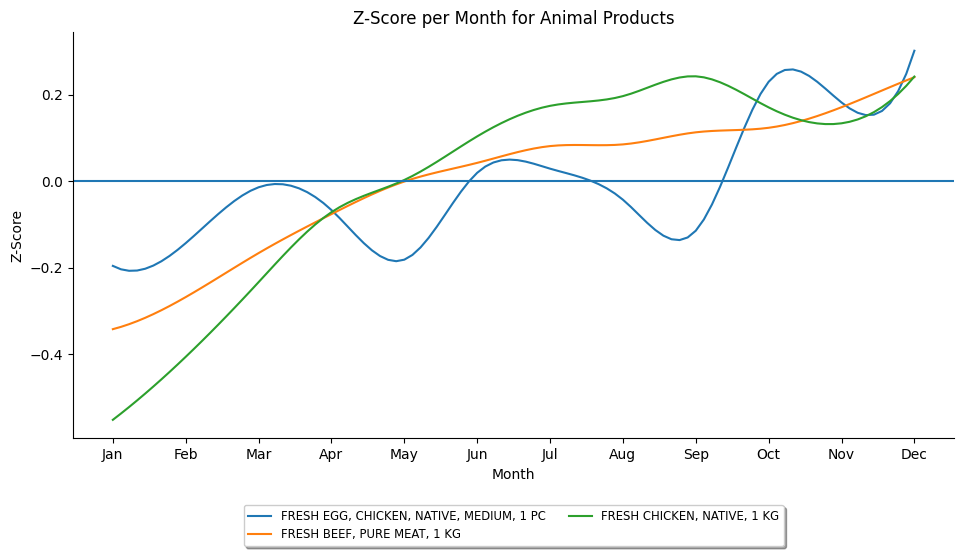

In [36]:
category_c = [
            "FRESH BEEF, PURE MEAT, 1 KG",
            "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
            "FRESH CHICKEN, NATIVE, 1 KG",         
        ]
plot_sd_difference(seasonality_results,category_c)


Group D: Seafood

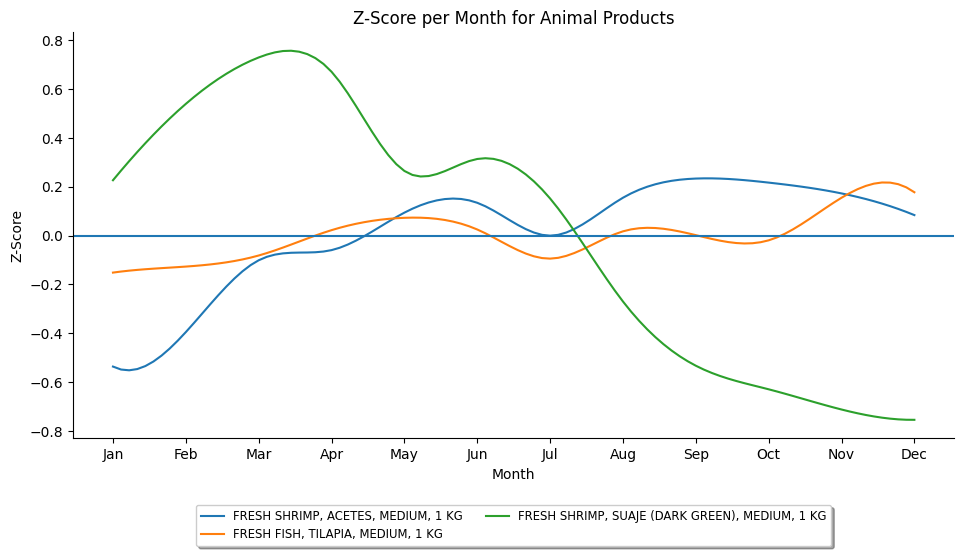

In [37]:
category_d = [
            "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
            "FRESH SHRIMP, ACETES, MEDIUM, 1 KG",
            "FRESH FISH, TILAPIA, MEDIUM, 1 KG"           
        ]
plot_sd_difference(seasonality_results, category_d)


### Broken Horizontal Bars for Nutshell

In [32]:
# I want to show peak months for each unique crop
from statistics import mean

for result in seasonality_results:
    crop = result['crop']
    average_price = mean(result['mean_per_month'])
    # print(f"{crop}: {average_price}")
    
    # for i in range(12):
    #     if result['mean_per_month'][i] > average_price:
    #         print(f"Peak month: {result['months'][i]}")
    
    

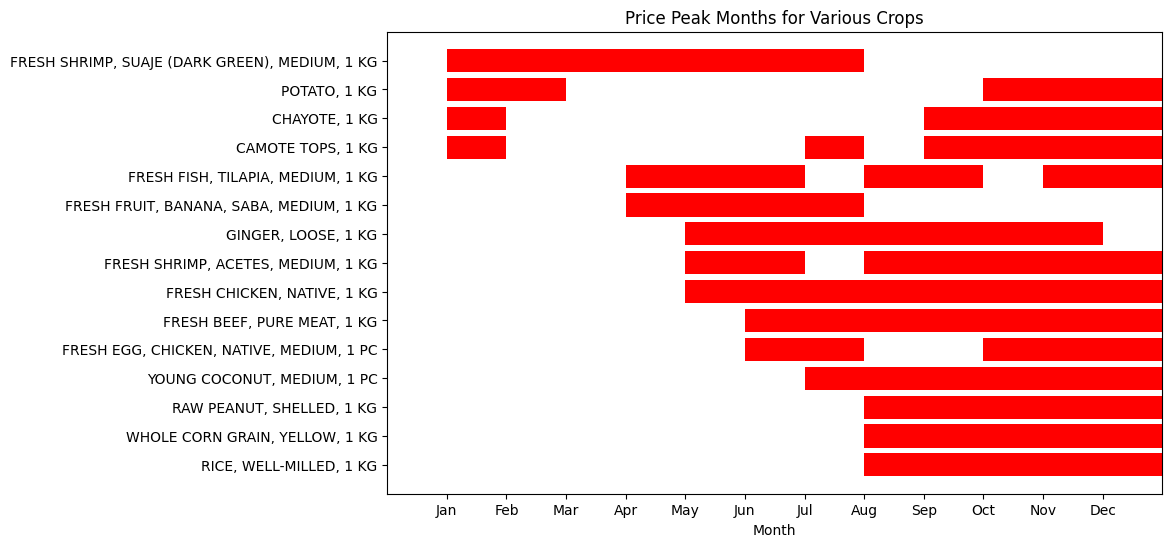

In [31]:
seasonality_results = seasonality_analysis(df, unique_crops)
seasonality_results

fig, ax = plt.subplots(figsize=(10, 6))

def swap(x, y):
    seasonality_results[x], seasonality_results[y] = seasonality_results[y], seasonality_results[x]

swap(12,14)
swap(2,13)
swap(5,12)
swap(6,11)
swap(2,10)
swap(7,9)
swap(4,8)
swap(5,7)
swap(2,4)
swap(2,3)


crop_positions = {result['crop']: i for i, result in enumerate(seasonality_results)}

for result in seasonality_results:
    crop = result['crop']
    average_price = mean(result['mean_per_month'])
    #print(f"{crop}: {average_price}")

    for i in range(12):
        month = result['months'][i]
        month_num = i + 1
        if result['mean_per_month'][i] > average_price:
            ax.broken_barh([(month_num, 1)], (crop_positions[crop] - 0.4, 0.8), facecolors="red")  # Highlight peak months


ax.set_yticks(range(len(seasonality_results)))
ax.set_yticklabels([result['crop'] for result in seasonality_results])


ax.set_xticks([i for i in range(1, 13)])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


ax.set_xlim(0, 13)
ax.set_ylim(-1, len(seasonality_results))

ax.grid(False)


ax.set_xlabel('Month')
ax.set_title('Price Peak Months for Various Crops')

plt.show()